## Load-in dependencies:

In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies) =#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [4]:
pwd()

"/home/xyu/github/BulkLMM.jl/analysis"

In [5]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
# Pkg.add("StatsBase")

In [10]:
using StatsBase

In [11]:
n_seeds = 20;

In [12]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

20-element Vector{Int64}:
 10
 17
 43
  5
 16
 69
 64
 78
 59
  7
 22
 96
  6
 87
 28
 39
 18
 82
 35
 25

## Three phases of data transformations:

In [13]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

In [14]:
# unique(round.(lambda0; digits = 3))

In [15]:
(r0, X00) = transform2(y0, X0, lambda0; reml = false);

## Study: distribute over permutations

### Check results:

Will the results be consistent, if we fixed the set of rotated data for further algorithm?

In [16]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [17]:
using Distributed

In [21]:
addprocs(10);

In [22]:
procs()

11-element Vector{Int64}:
  1
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19

In [20]:
# rmprocs(workers())

Task (done) @0x00007f2344ea4a20

In [23]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [23]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [24]:
size(pmap_LODs)

(2000, 7321)

In [25]:
pmap_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.0609393  0.0609393  0.0609393  0.0609393  0.0609393  0.0609393
 0.0829961  0.0829961  0.0829961  0.0829961  0.0829961  0.0829961
 0.540679   0.540679   0.540679   0.540679   0.540679   0.540679
 0.0118482  0.0118482  0.0118482  0.0118482  0.0118482  0.0118482
 0.493782   0.493782   0.493782   0.493782   0.493782   0.493782
 0.0472641  0.0472641  0.0472641  0.0472641  0.0472641  0.0472641

In [26]:
map_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.0609393  0.0609393  0.0609393  0.0609393  0.0609393  0.0609393
 0.0829961  0.0829961  0.0829961  0.0829961  0.0829961  0.0829961
 0.540679   0.540679   0.540679   0.540679   0.540679   0.540679
 0.0118482  0.0118482  0.0118482  0.0118482  0.0118482  0.0118482
 0.493782   0.493782   0.493782   0.493782   0.493782   0.493782
 0.0472641  0.0472641  0.0472641  0.0472641  0.0472641  0.0472641

In [27]:
maxSqDiff(map_LODs, pmap_LODs) 

0.0

It turned out that if we give the same set of rotated data, results will match, which implies that the inconsistency of results may only be due to the rotation process (sign ambiguity in eigendecomposition).

### Benchmarking:

map(permutations)

In [28]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 21.640 s (20.92% GC) to evaluate,
 with a memory estimate of 26.96 GiB, over 1474385 allocations.

pmap(permutations)

In [29]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 10.133 s (0.00% GC) to evaluate,
 with a memory estimate of 120.84 MiB, over 4916 allocations.

In [30]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 20.225 s (20.48% GC) to evaluate,
 with a memory estimate of 26.95 GiB, over 1474362 allocations.

In [31]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.349 s …   2.416 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.354 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.373 s ± 37.436 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   █                                                   █  
  █▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.35 s         Histogram: frequency by time        2.42 s <

 Memory estimate: 55.94 MiB, allocs estimate: 2436.

## Study: distribute over markers

### Check results:

In [32]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [33]:
size(r0perm) 
# 401 permutations of a vector of length 79 (79 measurements), plus the original, for results checking with scan_null

(79, 1001)

In [34]:
map_eachMarker_LODs = map(x -> scan_distributed(r0perm, X00, x), 1:7321);
map_eachMarker_LODs = reduce(vcat, map_eachMarker_LODs);

In [35]:
pmap_eachMarker_LODs = pmap(x -> scan_distributed(r0perm, X00, x), 1:7321);
pmap_eachMarker_LODs = reduce(vcat, pmap_eachMarker_LODs);

In [36]:
scan_null_original = scan(pheno_y, geno, kinship)[3]; # original trait vector LODs

In [37]:
map_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [38]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [39]:
scan_null_original[1:6]

6-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329331354
 0.008196360329331354
 0.008196360329322583
 0.008196360329322583

In [40]:
maxSqDiff(map_eachMarker_LODs, pmap_eachMarker_LODs)

7.888609052210118e-29

In [41]:
maxSqDiff(reshape(pmap_eachMarker_LODs[:, 1], :, 1), reshape(scan_null_original, :, 1))

3.155443620884047e-28

In [42]:
disLoops_LODs = scan_distributed(r0perm, X00);

In [43]:
disLoops_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [44]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [45]:
permutedims(scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

### Benchmarking:

In [46]:
@benchmark map(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 8.002 s (13.76% GC) to evaluate,
 with a memory estimate of 13.29 GiB, over 109817 allocations.

In [47]:
@benchmark pmap(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 13.347 s (0.00% GC) to evaluate,
 with a memory estimate of 79.00 MiB, over 521916 allocations.

In [48]:
@benchmark scan_distributed(r0perm, X00) # using distributed loops for each marker

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 42.644 s (0.00% GC) to evaluate,
 with a memory estimate of 223.80 MiB, over 7741 allocations.

In [49]:
 # using ordinary loops for each marker
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, original = true, rndseed = 0)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 8.139 s (13.85% GC) to evaluate,
 with a memory estimate of 13.30 GiB, over 117039 allocations.

In [50]:
range = 1:6;
typeof(range)

UnitRange{Int64}

## Study: distribute over blocks of markers

### Check results:

In [21]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [25]:
permutedims(scan_distributed_block(r0perm, X00, 1:6))[:, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182

In [30]:
## https://stackoverflow.com/questions/26953340/partition-equivalent-in-julia

function partition_array_indices(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

partition_array_indices (generic function with 1 method)

In [27]:
blocks_partitions = partition_array_indices(p, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [28]:
map_blocks_LODs = map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
map_blocks_LODs = permutedims(reduce(hcat, map_blocks_LODs));

In [29]:
map_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182

In [30]:
pmap_blocks_LODs = pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
pmap_blocks_LODs = permutedims(reduce(hcat, pmap_blocks_LODs));

In [31]:
pmap_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182

In [32]:
normal_LODs = scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true);
normal_LODs = permutedims(normal_LODs);

In [33]:
normal_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182
 0.00819636  1.13823  0.182157  0.0430406  1.02692  0.0273182

In [34]:
maxSqDiff(pmap_blocks_LODs, normal_LODs)

7.888609052210118e-29

### Benchmarking:

In [35]:
blocks_partitions

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [36]:
@benchmark map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.125 s …    4.228 s  ┊ GC (min … max): 33.92% … 49.04%
 Time  (median):     3.677 s               ┊ GC (median):    42.62%
 Time  (mean ± σ):   3.677 s ± 780.142 ms  ┊ GC (mean ± σ):  42.62% ± 10.69%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.12 s         Histogram: frequency by time         4.23 s <

 Memory estimate: 13.27 GiB, allocs estimate: 73284.

In [37]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.075 s …    2.388 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.367 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.276 s ± 174.766 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                     █  █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  2.07 s         Histogram: frequency by time         2.39 s <

 Memory estimate: 55.97 MiB, allocs estimate: 2006.

In [38]:
@benchmark begin 
    transform1(pheno_y, geno, kinship);
    transform2(y0, X0, lambda0);
    pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
end

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.291 s …   2.332 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.320 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.314 s ± 20.927 ms  ┊ GC (mean ± σ):  0.05% ± 0.09%

  █                                        █              █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.29 s         Histogram: frequency by time        2.33 s <

 Memory estimate: 82.88 MiB, allocs estimate: 2177.

In [39]:
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.671 s …   4.795 s  ┊ GC (min … max): 53.15% … 54.33%
 Time  (median):     4.733 s              ┊ GC (median):    53.75%
 Time  (mean ± σ):   4.733 s ± 87.324 ms  ┊ GC (mean ± σ):  53.75% ±  0.84%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.67 s         Histogram: frequency by time        4.79 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74637.

In [40]:
seeds_list

LoadError: UndefVarError: seeds_list not defined

In [41]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

LoadError: UndefVarError: seeds_list not defined

In [42]:
createBlocks(7332, 1000)

LoadError: UndefVarError: createBlocks not defined

In [43]:
ceil(7332/1000)

8.0

## Compare times for different choices of nperms and block sizes:

In [41]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [42]:
@everywhere nperms_list = [50, 100, 200, 500, 1000];
@everywhere bsizes_list = [100, 300, 500, 600, 1000];
@everywhere nblocks_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100];

In [27]:
runtimes_nperms = Array{Float64, 1}(undef, length(nperms_list));
runtimes_bsizes = Array{Float64, 1}(undef, length(bsizes_list));
runtimes_nblocks = Array{Float64, 1}(undef, length(nblocks_list));

In [28]:
procs() # check number of procs active rn

11-element Vector{Int64}:
  1
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19

In [70]:
# Pkg.add("StatsBase")

In [71]:
using StatsBase

In [73]:
for i in 1:length(nperms_list)
    
    np = nperms_list[i];
    nseeds = Int(1000/np);
    
    seeds_list = sample(1:100, nseeds; replace = false);
    b = @benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = $np, rndseed = x, original = false), $seeds_list);
    b = median(b)
    
    runtimes_nperms[i] = time(b)/1e9
    
end

In [65]:
for i in 1:length(bsizes_list)
    
    bs = bsizes_list[i];
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_bsizes[i] = time(b)/1e9
    
end

LoadError: InterruptException:

In [32]:
for i in 1:length(nblocks_list)
    
    bs = Int(ceil(p/nblocks_list[i]));
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), $blocks_partitions);
    b = median(b)
    
    runtimes_nblocks[i] = time(b)/1e9
    
end

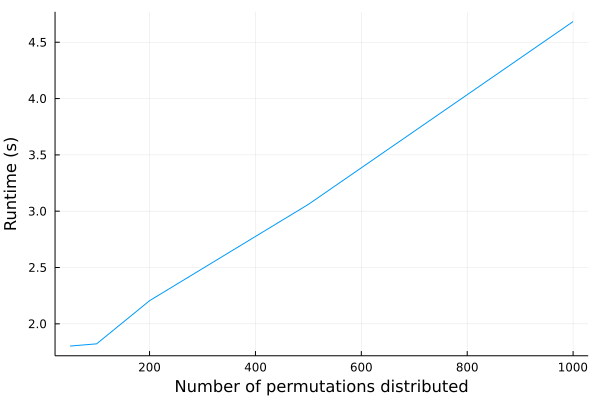

In [74]:
plot(nperms_list, runtimes_nperms; xlabel = "Number of permutations distributed", ylabel = "Runtime (s)", legend = false)

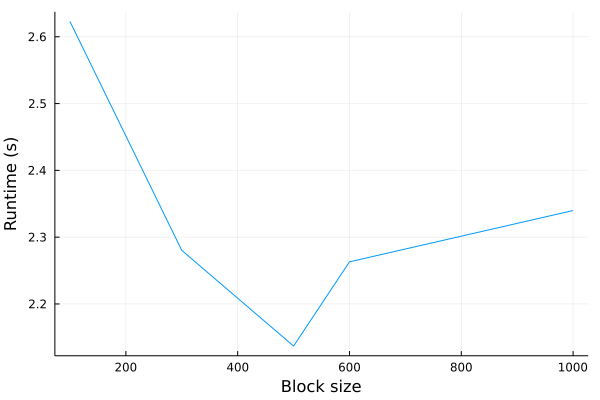

In [52]:
plot(bsizes_list, runtimes_bsizes; xlabel= "Block size", ylabel = "Runtime (s)", legend = false)

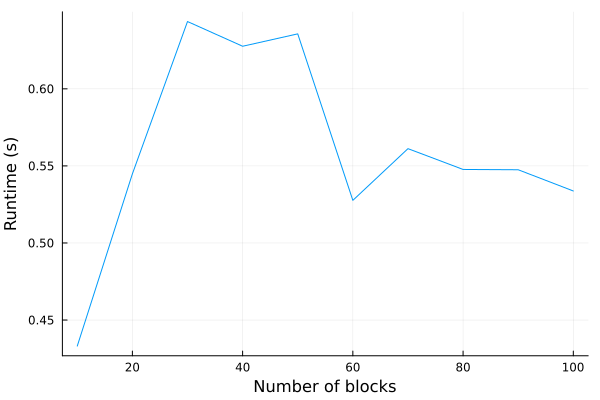

In [34]:
plot(nblocks_list, runtimes_nblocks; xlabel= "Number of blocks", ylabel = "Runtime (s)", legend = false)

By specifying the number of blocks needed...

In [35]:
p/1000

7.321

In [46]:
bs = Int(ceil(p/120));
blocks_partitions = partition_array_indices(p, bs)

119-element Vector{UnitRange{Int64}}:
 1:62
 63:124
 125:186
 187:248
 249:310
 311:372
 373:434
 435:496
 497:558
 559:620
 621:682
 683:744
 745:806
 ⋮
 6635:6696
 6697:6758
 6759:6820
 6821:6882
 6883:6944
 6945:7006
 7007:7068
 7069:7130
 7131:7192
 7193:7254
 7255:7316
 7317:7321

In [47]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  436.641 ms … 548.578 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     448.174 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   478.512 ms ±  47.383 ms  ┊ GC (mean ± σ):  0.39% ± 0.98%

  █ ▁ █ ▁     ▁                                    ▁  ▁   ▁   ▁  
  █▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁█▁▁▁█ ▁
  437 ms           Histogram: frequency by time          549 ms <

 Memory estimate: 56.29 MiB, allocs estimate: 9393.

In [57]:
reduce(hcat, pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions))

1001×7321 Matrix{Float64}:
 0.00819636   0.00819636   …  0.0449878    0.0128283   0.0128283
 0.604956     0.604956        1.33928      1.29426     1.29426
 0.0264842    0.0264842       0.16927      0.069518    0.069518
 0.00585467   0.00585467      0.589608     0.14854     0.14854
 0.477297     0.477297        0.0317133    0.0625366   0.0625366
 0.140293     0.140293     …  0.0400303    0.0338204   0.0338204
 0.45141      0.45141         0.459152     0.278652    0.278652
 0.179818     0.179818        0.0430329    0.0218039   0.0218039
 0.213351     0.213351        0.179031     0.193549    0.193549
 0.0250041    0.0250041       0.0679043    0.00622826  0.00622826
 0.801668     0.801668     …  0.42936      0.123412    0.123412
 0.0351507    0.0351507       0.296432     0.0480549   0.0480549
 0.053255     0.053255        0.281489     0.11254     0.11254
 ⋮                         ⋱                           ⋮
 0.104779     0.104779        0.159406     0.0806087   0.0806087
 0.552277     0

In [82]:
nblocks = 140;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

141-element Vector{UnitRange{Int64}}:
 1:52
 53:104
 105:156
 157:208
 209:260
 261:312
 313:364
 365:416
 417:468
 469:520
 521:572
 573:624
 625:676
 ⋮
 6709:6760
 6761:6812
 6813:6864
 6865:6916
 6917:6968
 6969:7020
 7021:7072
 7073:7124
 7125:7176
 7177:7228
 7229:7280
 7281:7321

In [43]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  422.230 ms … 561.816 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     443.351 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   473.718 ms ±  54.315 ms  ┊ GC (mean ± σ):  0.19% ± 0.45%

  ▁  █   ▁ █      ▁        ▁                             ▁ ▁  ▁  
  █▁▁█▁▁▁█▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁█ ▁
  422 ms           Histogram: frequency by time          562 ms <

 Memory estimate: 56.28 MiB, allocs estimate: 9380.

In [84]:
nblocks = 200;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

204-element Vector{UnitRange{Int64}}:
 1:36
 37:72
 73:108
 109:144
 145:180
 181:216
 217:252
 253:288
 289:324
 325:360
 361:396
 397:432
 433:468
 ⋮
 6913:6948
 6949:6984
 6985:7020
 7021:7056
 7057:7092
 7093:7128
 7129:7164
 7165:7200
 7201:7236
 7237:7272
 7273:7308
 7309:7321

In [85]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.519 s …   4.653 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.586 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.586 s ± 94.796 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.52 s         Histogram: frequency by time        4.65 s <

 Memory estimate: 56.64 MiB, allocs estimate: 20904.

In [86]:
Int(floor(p/10))

732

In [87]:
partition_array_indices(p, 732)

11-element Vector{UnitRange{Int64}}:
 1:732
 733:1464
 1465:2196
 2197:2928
 2929:3660
 3661:4392
 4393:5124
 5125:5856
 5857:6588
 6589:7320
 7321:7321

## Miscellaneous:

In [24]:
# Pkg.add("ParallelDataTransfer");

In [48]:
include("../src/scan.jl")

distribute_by_nperms (generic function with 1 method)

In [49]:
# addprocs(4)

In [50]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [51]:
@everywhere include("../src/parallel_helpers.jl")

In [52]:
createBlocks(7321, 1000)

1000-element Vector{UnitRange{Int64}}:
 1:7
 8:14
 15:21
 22:28
 29:35
 36:42
 43:49
 50:56
 57:63
 64:70
 71:77
 78:84
 85:91
 ⋮
 6917:6923
 6924:6930
 6931:6937
 6938:6944
 6945:6951
 6952:6958
 6959:6965
 6966:6972
 6973:6979
 6980:6986
 6987:6993
 6994:7321

In [65]:
createBlocks2(7321, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [54]:
procs()

11-element Vector{Int64}:
  1
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19

In [63]:
scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 1000)

1001×7321 Matrix{Float64}:
 0.00819636   0.00819636   …  0.0449878    0.0128283   0.0128283
 0.604956     0.604956        1.33928      1.29426     1.29426
 0.0264842    0.0264842       0.16927      0.069518    0.069518
 0.00585467   0.00585467      0.589608     0.14854     0.14854
 0.477297     0.477297        0.0317133    0.0625366   0.0625366
 0.140293     0.140293     …  0.0400303    0.0338204   0.0338204
 0.45141      0.45141         0.459152     0.278652    0.278652
 0.179818     0.179818        0.0430329    0.0218039   0.0218039
 0.213351     0.213351        0.179031     0.193549    0.193549
 0.0250041    0.0250041       0.0679043    0.00622826  0.00622826
 0.801668     0.801668     …  0.42936      0.123412    0.123412
 0.0351507    0.0351507       0.296432     0.0480549   0.0480549
 0.053255     0.053255        0.281489     0.11254     0.11254
 ⋮                         ⋱                           ⋮
 0.104779     0.104779        0.159406     0.0806087   0.0806087
 0.552277     0

In [64]:
scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, original = true, 
    option = "by nperms", ncopies = 10)

1001×7321 Matrix{Float64}:
 0.00819636  0.00819636  0.00819636  0.00819636  …  0.0128283    0.0128283
 0.27209     0.27209     0.27209     0.27209        0.0322812    0.0322812
 0.00179681  0.00179681  0.00179681  0.00179681     0.0802721    0.0802721
 0.869349    0.869349    0.869349    0.869349       0.110376     0.110376
 0.00256127  0.00256127  0.00256127  0.00256127     0.894692     0.894692
 0.129985    0.129985    0.129985    0.129985    …  0.253105     0.253105
 0.171746    0.171746    0.171746    0.171746       0.185423     0.185423
 0.0195727   0.0195727   0.0195727   0.0195727      0.217267     0.217267
 0.112309    0.112309    0.112309    0.112309       0.347915     0.347915
 0.156188    0.156188    0.156188    0.156188       0.000510834  0.000510834
 0.326637    0.326637    0.326637    0.326637    …  0.962135     0.962135
 0.32494     0.32494     0.32494     0.32494        0.348019     0.348019
 0.285773    0.285773    0.285773    0.285773       0.24345      0.24345
 ⋮    

In [58]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 10)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.532 s …   1.728 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.540 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.585 s ± 95.774 ms  ┊ GC (mean ± σ):  0.25% ± 0.51%

  ██ █                                                    █  
  ██▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.53 s         Histogram: frequency by time        1.73 s <

 Memory estimate: 142.61 MiB, allocs estimate: 63727.

In [62]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 1000)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  590.534 ms … 827.203 ms  ┊ GC (min … max): 0.00% … 2.82%
 Time  (median):     776.620 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   753.427 ms ±  76.261 ms  ┊ GC (mean ± σ):  0.54% ± 1.05%

  ▁                                        █     ▁▁   ▁       ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁██▁▁▁█▁▁▁▁▁▁▁█ ▁
  591 ms           Histogram: frequency by time          827 ms <

 Memory estimate: 140.10 MiB, allocs estimate: 2354.

In [88]:
n = size(y0, 1)

79

In [89]:
Loops_y0 = Array{Float64, 2}(undef, n, 10);

In [90]:
for i = 1:10
    Loops_y0[:, i] = rotateData(pheno_y, geno, kinship)[1]
end

first_col = Loops_y0[:, 1];

In [91]:
test_list = mapslices(x -> x .- first_col, Loops_y0; dims = 1);

In [92]:
test_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [93]:
# addprocs(7);
procs()

3-element Vector{Int64}:
 1
 2
 3

In [94]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using DelimitedFiles
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [95]:
@everywhere begin 
    pheno_file = "../data/bxdData/BXDtraits.csv"
    pheno = readBXDpheno(pheno_file);
    geno_file = "../data/bxdData/BXDgeno_prob.csv"
    geno = readGenoProb_ExcludeComplements(geno_file);

    kinship = calcKinship(geno); # calculate kinship matrix from genotype data
end

In [96]:
procs()

3-element Vector{Int64}:
 1
 2
 3

In [97]:
# rmprocs([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [98]:
disLoops_y0 = @distributed (hcat) for i = 1:10
    rotateData(pheno_y, geno, kinship)[1]
end

first_dis_col = disLoops_y0[:, 1];


In [99]:
test_dis_list = mapslices(x -> x .- first_dis_col, disLoops_y0; dims = 1);
test_dis_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [100]:
pmaps_y0

LoadError: UndefVarError: pmaps_y0 not defined

In [101]:
Loops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
  0.533096      0.533096      0.533096         0.533096      0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
  0.185084      0.185084      0.185084         0.185084      0.185084
 -0.0298419    -0.0298419    -0.0298419       -0.0298419    -0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
 -0.0267104    -0.0267104    -0.0267104       -0.0267104    -0.0267104
  0.236609      0.236609      0.236609         0.236609      0.

In [102]:
disLoops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
 -0.533096     -0.533096     -0.533096        -0.533096     -0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
 -0.185084     -0.185084     -0.185084        -0.185084     -0.185084
  0.0298419     0.0298419     0.0298419        0.0298419     0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
  0.0267104     0.0267104     0.0267104        0.0267104     0.0267104
 -0.236609     -0.236609     -0.236609        -0.236609     -0.

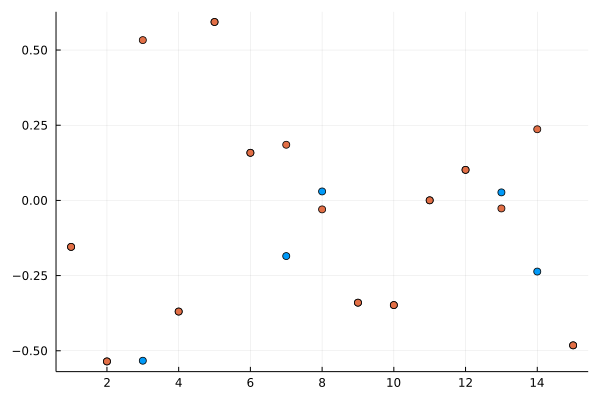

In [103]:
scatter(disLoops_y0[1:15, 1])
scatter!(Loops_y0[1:15, 1]; legend = false)

In [104]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)